Purpose: To investigate what fraction of the PHAs (or NEOs) might be discovered before or during LSST operations by other telescope, and then add these to LSST's total to see the effect of LSST + previous discoveries. 

As we use synthetic model populations (not actual populations) and do not know the survey pointing history for previous surveys, we simulate what would have been "previously discovered" by taking our model population and identifying a V magnitude threshhold which matches approximately what is known now or what will be known at the start of LSST operations. 

As a proxy for simulating the entire population + pointing histories for existing surveys, we can assume that all NEOs larger than 140m which get brighter than a given V magnitude threshhold will be discovered. Spacewatch has been in operation since 1984, CSS has been a considerable influence in NEO discovery since 2005, etc. According to the JPL NEO discovery page (http://neo.jpl.nasa.gov/stats/) we could estimate conservatively that discovery of 140m NEOs started in earnest in 2000 -- implying (a conservative) 15 years to reach the current 25% level (and the discovery rate of 140m and larger NEOs seems roughly constant over that time period, with a recent uptick of about 20% per year).  GMS16 (https://arxiv.org/pdf/1604.03444v1.pdf) indicates that the current completeness of NEOs larger than 140m is about 25% (Mainzer et al 2011) and is expected to be 43% when LSST comes online.

Thus we take our sample of NEOs, integrate their orbits over 15 years (generating ephemerides once per night), and look at their peak brightness over that time period. We then choose a peak brightness threshhold that corresponds to detecting 25% of the total NEOs larger than 140m (H=22). 

In [1]:
import os 
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
%matplotlib inline

Read bright object observations. I've generated ephemerides over 15 years from 2000 to 2015 (corresponding to the 15 years leading up to 'now' described above), for both NEOs and PHAs. By picking the correct V mag threshhold, we should see about 25% completeness at H=22. I've also generated ephemerides of the same objects reaching all the way to the start of LSST operations (2022), so as to calculate the expected completeness at the start of LSST operations (GMS16 indicate this should be about 43%). 

In [2]:
import pandas as pd
ephemFile = {}
ephemFile['pha15'] = '/Users/lynnej/ephems/phas_15.dat'  # PHA ephems from 2000-2015
ephemFile['neo15'] = '/Users/lynnej/ephems/neos_15.dat'  # NEO ephems from 2000-2015
ephemFile['pha22'] = '/Users/lynnej/ephems/phas_22.dat'  # PHA ephems from 2000-2022
ephemFile['neo22'] = '/Users/lynnej/ephems/neos_22.dat'  # NEO ephems from 2000-2022
ephems = {}
for t in ephemFile:
    ephems[t] = pd.read_table(ephemFile[t], delim_whitespace=True)

In [3]:
# Add some columns to the ephem file - these are used to calculate appMagV.
def add_velocity(ephs):
    ephs['velocity'] = np.sqrt(ephs['dRAdt']**2 + ephs['dDecdt']**2)
    return ephs

def calcMagLosses(ephs, seeing=0.75, texp=30.):
    """
    Calculate the magnitude losses due to trailing and not matching the point-source detection filter.
    """
    a_trail = 0.76
    b_trail = 1.16
    a_det = 0.42
    b_det = 0.00
    x = ephs['velocity'] * texp / seeing / 24.0
    ephs['dmagTrail'] = 1.25 * np.log10(1 + a_trail*x**2/(1+b_trail*x))
    ephs['dmagDetect'] = 1.25 * np.log10(1 + a_det*x**2 / (1+b_det*x))
    return ephs

In [4]:
# Add some more 'dummy' columns to ephem file - these just need to be there for SNR/vis/magFilter calculation, but
# we won't use them for peakV / known object calculation.
def add_dummycols(ephs):
    ephs['magFilter'] = ephs['magV']
    ephs['fiveSigmaDepth'] = np.ones(len(ephs), float) * 28.0
    return ephs

In [5]:
for t in ephems:
    ephems[t] = add_velocity(ephems[t])
    ephems[t] = calcMagLosses(ephems[t])
    ephems[t] = add_dummycols(ephems[t])
    cols = ephems[t].columns.values
    cols[0] = 'objId'
    ephems[t].columns = cols

In [6]:
ephems['neo15'][0:3]

,objId,MJD(UTC),RA,Dec,dRAdt,dDecdt,Delta,magV,Elongation,velocity,dmagTrail,dmagDetect,magFilter,fiveSigmaDepth
0,1,51544.16,277.368902,-20.498749,0.401307,0.039902,3.694117,15.497170,4.168532,0.403285,0.095767,0.094318,15.497170,28.0
1,1,51545.16,277.793599,-20.458428,0.401481,0.041179,3.691638,15.511805,4.662041,0.403587,0.095870,0.094447,15.511805,28.0
2,1,51546.16,278.218350,-20.416818,0.401636,0.042458,3.688993,15.526632,5.182572,0.403874,0.095967,0.094570,15.526632,28.0


Set up MAF. We will use both observations from LSST to calculate the actual objects LSST will discover, and the ephemerides above to calculate what could have been discovered previously.

In [7]:
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.db as db
import lsst.sims.maf.metricBundles as mmb
import lsst.sims.maf.utils as utils

In [8]:
import sys
try:
    sys.path.remove('/Users/lynnej/work/lsst')
except ValueError:
    pass
sys.path.append(os.path.join(os.getenv('SIMS_MAF_DIR'), 'bin'))
import movingObjects as moO

/Users/lynnej/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [9]:
orbitFile = {}
orbitFile['pha'] = 'orbits/pha20141031.des'
orbitFile['neo'] = 'orbits/neos_2k.des'

In [10]:
Hmark = 22
Hrange = np.arange(11, 28.5, 0.5)
Hidx = np.where(Hrange == 22)[0]
outDir = 'test'
if not (os.path.isdir(outDir)):
    os.makedirs(outDir)

In [11]:
# Set up the moving object slicers for each of these ephemeride files.
slicerEphs =  {}
for t in ephems:
    slicerEphs[t] = moO.setupSlicer(orbitFile[t[0:3]], Hrange, obsFile=None)
    slicerEphs[t].obs = ephems[t]
    slicerEphs[t].allObs = ephems[t]
    slicerEphs[t].obsfile = ephemFile[t]

In [12]:
# And set up the moving object metricBundles.
plotFuncs = [plots.MetricVsH()]

knownBundle = {}
peakVBundle = {}
for t in slicerEphs:
    plotDict = {'nxbins': 200, 'nybins': 200,
                'title': '%s: %s' % ("Previously known", t)}
    
    metric = metrics.KnownObjectsMetric(vMagThresh=20.0)
    knownBundle[t] = mmb.MoMetricBundle(metric, slicerEphs[t], None, 
                                        runName="Previously known", metadata=t,
                                        plotDict=plotDict, plotFuncs=plotFuncs)

    metric = metrics.PeakVMagMetric()
    peakVBundle[t] = mmb.MoMetricBundle(metric, slicerEphs[t], None,
                                        runName="Previously known", metadata=t,
                                        plotDict=plotDict, plotFuncs=plotFuncs)

In [13]:
# Calculate  the peak V magnitude and associated known/unknown flags for each object
for t in slicerEphs:
    bg = mmb.MoMetricBundleGroup({0:knownBundle[t], 1: peakVBundle[t]}, outDir=outDir, resultsDb=None)
    bg.runAll()

Running metrics [0, 1]


/Users/lynnej/lsstRepos/sims_maf/python/lsst/sims/maf/stackers/baseStacker.py:121: UserWarning: Warning - column appMagV already present in simData, will be overwritten.
  %(col))
/Users/lynnej/lsstRepos/sims_maf/python/lsst/sims/maf/stackers/baseStacker.py:121: UserWarning: Warning - column appMag already present in simData, will be overwritten.
  %(col))
/Users/lynnej/lsstRepos/sims_maf/python/lsst/sims/maf/stackers/baseStacker.py:121: UserWarning: Warning - column SNR already present in simData, will be overwritten.
  %(col))
/Users/lynnej/lsstRepos/sims_maf/python/lsst/sims/maf/stackers/baseStacker.py:121: UserWarning: Warning - column vis already present in simData, will be overwritten.
  %(col))


Calculated and saved all metrics.
Running metrics [0, 1]
Calculated and saved all metrics.
Running metrics [0, 1]
Calculated and saved all metrics.
Running metrics [0, 1]
Calculated and saved all metrics.


We need to calculate the V magnitude threshhold corresponding to discovering 25% of NEOs bigger than H=22 between 2000-2015 (i.e., in the 15 year sample). For this we just look at all peak V magnitudes, and look at the sample 'completeness' corresponding to varying the V magnitude threshhold. 

We find that 25% corresponds to a V threshhold of 20.0, which is very roughly consistent with limiting magnitudes of the biggest contributors -- Catalina Sky Survey can go to V=21.5, although threshholds described as 19-21 (probably across different weather and lunar phase?), and PS1 can go to V=22 although again much variety (especially when including moving object pipeline stuff?). 

In [14]:
def calcFrac(peakVmags, Hvals, Vthresh, cumulative=True):
    nSsos = peakVmags.shape[0]
    peakVinH = peakVmags.swapaxes(0, 1)
    completeness = np.zeros(len(Hvals), float)
    for i, H in enumerate(Hvals):
        completeness[i] = np.where(peakVinH[i].filled(100) <= Vthresh)[0].size
    completeness = completeness / float(nSsos)
    if cumulative:
        completeness = metrics.integrateOverH(completeness, Hvals)
    return completeness

In [46]:
# Find the V mag threshhold corresponding to 25% completeness for H<=22, at the present time.
thresh = 20.0
comp = calcFrac(peakVBundle['neo15'].metricValues, Hrange, thresh)
print "At %f Vmag threshhold, find %f completeness for H<=22" % (thresh, comp[Hidx][0])

At 20.000000 Vmag threshhold, find 0.257953 completeness for H<=22


In [48]:
# But we should also match the completeness estimate for 1 km objects (17.75, or about 18), which is around 90%.
print "At bright end, 1km objects, find %f completeness" % (comp[np.where(Hrange==18)])

At bright end, 1km objects, find 0.953638 completeness


In [50]:
# Calculate what completeness would be with same rate/instrumentation at start of LSST.
comp = calcFrac(peakVBundle['neo22'].metricValues, Hrange, 20.0)
print 'At start of LSST operations, with same Vmag threshhold, expect %f completeness H<=22' % (comp[Hidx][0])

At start of LSST operations, with same Vmag threshhold, expect 0.295974 completeness H<=22


In [51]:
# Check one of Zeljko's numbers, which was fraction of the population which will not get brighter than V=24
comp = calcFrac(peakVBundle['neo22'].metricValues, Hrange, 24)
print "Fraction of the NEO population @ h<=22 which never brighter than V=24 in 22 years: %f" %(1 - comp[Hidx])

Fraction of the NEO population @ h<=22 which never brighter than V=24 in 22 years: 0.030651


So that tells us about what could have been discovered prior to LSST (and at the present time). 

Now let's look at what LSST would have found, with our more realistic discovery criteria (3 nights of pairs, within 15 days).  Read the discovery metric results back from disk, so we can look at what LSST would have found. 

In [18]:
opsim = 'minion_1016'
#opsim = 'astro_lsst_01_1016'
obsFile = {}
dataDir = {}
obsFile['pha'] = os.path.join(opsim, '%s_newsky__%s' % (opsim, 'pha20141031_obs.txt'))
dataDir['pha'] = os.path.join(opsim, 'pha_newsky')
obsFile['neo'] = os.path.join(opsim, '%s_newsky__%s' % (opsim, 'neos_2k_obs.txt'))
dataDir['neo'] = os.path.join(opsim, 'neo_newsky')

maxYears = 10
nyears = np.arange(2, maxYears+1, 2)
nyears = np.concatenate([[1], nyears])
if maxYears not in nyears:
    nyears = np.concatenate([nyears, [maxYears]])

In [19]:
slicer = {}
for  t in ['pha', 'neo']:
    slicer[t] = moO.setupSlicer(orbitFile[t], Hrange, obsFile=obsFile[t])

In [20]:
strategy = '3 pairs in 15 nights'
discovery = {}
for t in ['pha', 'neo']:
    plotDict = {'nxbins': 200, 'nybins': 200,
                'title': '%s: %s' % (opsim, t)}
    metric = metrics.DiscoveryMetric(nObsPerNight=2, tMin=0, tMax=90./60./24.,
                                     nNightsPerWindow=3, tWindow=15)
    discovery[t] = mmb.MoMetricBundle(metric, slicer[t], None,
                                      runName=opsim, metadata=t,
                                      plotDict=plotDict, plotFuncs=plotFuncs)
    fileroot = ' '.join([opsim, 'Discovery_N_Chances_n3650', t.upper(), strategy, 'MOOB'])
    discovery[t].fileRoot = utils.nameSanitize(fileroot)
    discovery[t] = moO.readMetricValues(discovery[t], dataDir[t])

In [52]:
def discovery_boost(previouslyKnown, lsstDiscoveryChances, Hvals, cumulative=True):
    previouslyKnown = np.where(previouslyKnown <= 20.0, 1, 0)
    lsstFound = np.where(lsstDiscoveryChances >= 1, 1, 0)
    boost = np.where((previouslyKnown == 1) & (lsstFound == 0), 1, 0)
    nSsos = boost.shape[0]
    boostH = boost.swapaxes(0, 1)
    completeness = np.zeros(len(Hvals), float)
    for i, H in enumerate(Hvals):
        completeness[i] = np.where(boostH[i] == 1)[0].size
    completeness = completeness / float(nSsos)
    if cumulative:
        completeness = metrics.integrateOverH(completeness, Hvals)
    return completeness    

In [53]:
boost = discovery_boost(peakVBundle['neo22'].metricValues, discovery['neo'].metricValues, Hrange, cumulative=True)
print "Boost to LSST discovery of H<=22: %f" % (boost[Hidx][0])
print "Boost to LSST discovery at the bright end: %f" %(boost[[0]][0])

Boost to LSST discovery of H<=22: 0.066395
Boost to LSST discovery at the bright end: 0.094047


We can also calculate the LSST 'completeness' in a manner similar as we did for other surveys above, using a simple set of nightly ephemerides and determing the equivalent V mag threshhold for LSST to reach a completeness similar to what we expected above. 

In [65]:
lsstEphemFile = {}
lsstEphemFile['pha'] = '/Users/lynnej/ephems/pha_10years.dat'  # PHA ephems from 2022-2032
lsstEphemFile['neo'] = '/Users/lynnej/ephems/neos_10years.dat' # NEO ephems from 2022-2032
lsstEphems = {}
for t in lsstEphemFile:
    lsstEphems[t] = pd.read_table(lsstEphemFile[t], delim_whitespace=True)

In [66]:
for t in lsstEphems:
    lsstEphems[t] = add_velocity(lsstEphems[t])
    lsstEphems[t] = calcMagLosses(lsstEphems[t])
    lsstEphems[t] = add_dummycols(lsstEphems[t])
    cols = lsstEphems[t].columns.values
    cols[0] = 'objId'
    lsstEphems[t].columns = cols

In [67]:
# Set up the moving object slicers for each of these ephemeride files.
slicerLsstEphs =  {}
for t in lsstEphems:
    slicerLsstEphs[t] = moO.setupSlicer(orbitFile[t[0:3]], Hrange, obsFile=None)
    slicerLsstEphs[t].obs = lsstEphems[t]
    slicerLsstEphs[t].allObs = lsstEphems[t]
    slicerLsstEphs[t].obsfile = lsstEphemFile[t]

In [68]:
# And set up the moving object metricBundles.
plotFuncs = [plots.MetricVsH()]

knownBundle = {}
peakVBundle = {}
for t in slicerLsstEphs:
    plotDict = {'nxbins': 200, 'nybins': 200,
                'title': '%s: %s' % ("LSST discoveries", t)}
    metric = metrics.PeakVMagMetric()
    peakVBundle[t] = mmb.MoMetricBundle(metric, slicerLsstEphs[t], None,
                                        runName="LSST discoveries", metadata=t,
                                        plotDict=plotDict, plotFuncs=plotFuncs)

In [70]:
for t in slicerLsstEphs:
    bg = mmb.MoMetricBundleGroup({0: peakVBundle[t]}, outDir=outDir, resultsDb=None)
    bg.runAll()

Running metrics [0]
Calculated and saved all metrics.
Running metrics [0]
Calculated and saved all metrics.


In [79]:
# Find the V mag threshhold corresponding to 25% completeness for H<=22, at the present time.
lsstthresh = 22.2
comp = calcFrac(peakVBundle['neo'].metricValues, Hrange, lsstthresh)
print "At %f Vmag threshhold, find %f completeness for H<=22 during 10 years of LSST" % (lsstthresh, comp[Hidx][0])
print "This compares to 61% completeness calculated using full discovery metric in minion_1016."

At 22.200000 Vmag threshhold, find 0.623578 completeness for H<=22 during 10 years of LSST
This compares to 61% completeness calculated using full discovery metric in minion_1016.


In [80]:
# Calculate peakVMag for the actual observations, just as a double-check
lsst_peakVBundle = {}
for t in ['pha', 'neo']:
    plotDict = {'nxbins': 200, 'nybins': 200,
                'title': '%s: %s' % (opsim, t)}
    metric = metrics.PeakVMagMetric()
    lsst_peakVBundle[t] = mmb.MoMetricBundle(metric, slicer[t], None,
                                            runName=opsim, metadata=t,
                                            plotDict=plotDict, plotFuncs=plotFuncs)

In [81]:
for t in ['pha', 'neo']:
    bg = mmb.MoMetricBundleGroup({0: lsst_peakVBundle[t]}, outDir=outDir, resultsDb=None)
    bg.runAll()

Running metrics [0]
Calculated and saved all metrics.
Running metrics [0]
Calculated and saved all metrics.


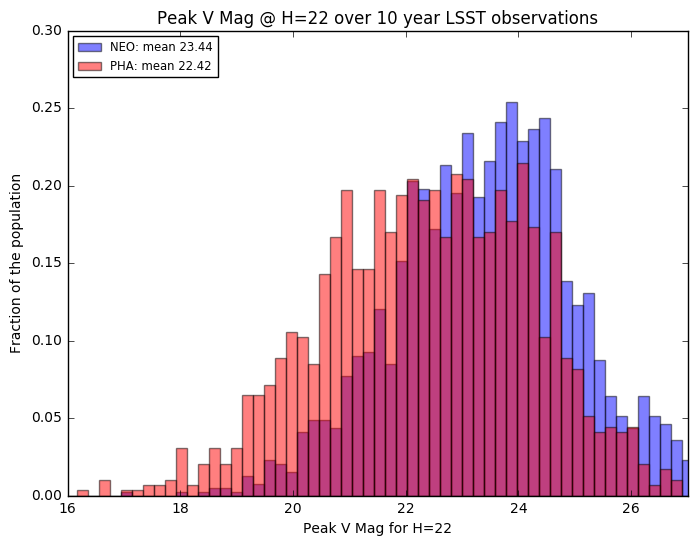

In [82]:
Hidx = np.where(Hrange == 22)[0]
lpha = np.swapaxes(lsst_peakVBundle['pha'].metricValues, 0, 1)[Hidx][0]
lneo = np.swapaxes(lsst_peakVBundle['neo'].metricValues, 0, 1)[Hidx][0]

plt.figure(figsize=(8, 6))
meanV = np.mean(lneo)
n, b, p = plt.hist(lneo, bins=150, normed=True, color='b', alpha=0.5, label='NEO: mean %.2f' % meanV)
meanV = np.mean(lpha)
n, b, p = plt.hist(lpha, bins=b, normed=True, color='r', alpha=0.5, label='PHA: mean %.2f' % meanV)
plt.xlim(16, 27)
plt.legend(loc='upper left', fontsize='smaller')
plt.title('Peak V Mag @ H=22 over 10 year LSST observations')
plt.xlabel('Peak V Mag for H=22')
plt.ylabel('Fraction of the population')
plt.savefig('lsst_peakVmag.pdf')